In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
from shuttle_helpers import load
c = 0 #index of the conditional variable variable
train, test = load(c=c)
# too big to easily process on 1 GPU.
# Let us split it in 3 datasets
seed = 2
assert (seed>=0) & (seed<=2)
train = train[seed::3]
test  =  test[seed::3]
print(train.shape, test.shape)

# with open("shuttle.trn","r") as f:
#     all_lines = f.read()
    
# lines = all_lines.split('\n')
# train = np.array([[float(n) for n in l.split(' ')] for l in lines[:-1]])

# with open("shuttle.tst","r") as f:
#     all_lines = f.read()
    
# lines = all_lines.split('\n')
# test = np.array([[float(n) for n in l.split(' ')] for l in lines[:-1]])

# seed = 2
# train = train[seed::3]
# test = test[seed::3]
# size = train.shape[0]

# print(train.shape, test.shape)

# numbers = np.concatenate([train,test])
# numbers[:,c] = (np.argsort(numbers[:,c].flatten()).argsort()/numbers[:,c].size).reshape(numbers[:,c].shape)
# train = numbers[:size]
# test = numbers[size:]
# print(train.shape, test.shape)

(14500, 10) (4833, 10)
(14500, 10) (4833, 10)
(14500, 10) (4833, 10)


In [3]:
import sys
sys.path.insert(0, '../../') #back to the project folder from ./examples/shuttle/
from marginal import heuristic_element_order
numbers = np.concatenate([train,test])
order = heuristic_element_order(numbers) 
# order is different for train vs. test, but we follow the vine.R by Hernandez-Lobato
order

array([7, 4, 9, 8, 0, 6, 2, 5, 1, 3])

In [4]:
import marginal as mg
from tqdm.notebook import tqdm
X = train[:,c]
Xt = test[:,c]
Y_raw = train[:,order[order!=c]]
Yt_raw = test[:,order[order!=c]]
# conditional
Y = np.zeros_like(Y_raw)
Yt = np.zeros_like(Yt_raw)
for i, (y,yt) in tqdm(enumerate(zip(Y_raw.T,Yt_raw.T))):
    # conditional
    Y[:,i] = mg.fast_signal2uniform(y,X,old=True)
    Yt[:,i] = mg.fast_signal2uniform(y,X,Y_=yt,X_=Xt,old=True)

# # unconditional
# Y = Y_raw
# Yt = Yt_raw

# now [0,1] -> [0.001,0.999] for computational stability
min = np.concatenate([Y,Yt]).min(0)
max = np.concatenate([Y,Yt]).max(0)
Y = mg.normalize_Y(Y,min,max)
Yt = mg.normalize_Y(Yt,min,max)

(14500,)

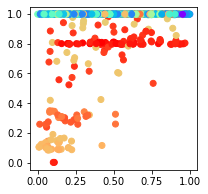

In [5]:
import matplotlib.cm as cm

plt.figure(figsize=(3,3))
skip = 4
plt.scatter(*Yt[::skip,[0,2]].T,color=cm.rainbow(Xt[::skip]))
X.shape

In [12]:
##############################
#       Train                #
##############################

# # Option 1: light (no files saved to disk)
# from train import train_vine_light

# gpus = [0,1]
# %time result = train_vine_light(X,Y,gauss=True,device_list=[f'cuda:{i}' for i in gpus])
# trained = {'X': X, 'Xt': Xt, 'Y': Y, 'Yt': Yt, 'X_label' : 'time'}
# trained.update(result)

# path_final = f"/home/nina/CopulaGP/examples/shuttle/outputs/shuttleG_trained.pkl"
# with open(path_final,"wb") as f:
#     pkl.dump(trained,f)

In [6]:
# Option 2: layer by layer, saving checkpoints
from train import train_vine

# first, set up the pathes

path2data = '/home/nina/CopulaGP/examples/shuttle'
exp = f'shuttle{seed}'
g = ''
path_data = lambda layer: f"{path2data}/outputs/{exp}{g}_layer{layer}.pkl"
path_models = lambda layer: f"{path2data}/outputs/{exp}{g}_models_layer{layer}.pkl"
path_final = f"{path2data}/outputs/{exp}{g}_trained.pkl"

d = {'X': X, 'Xt': Xt, 'Y': Y, 'Yt': Yt, 'X_label' : 'time'}
with open(path_data(0),'wb') as f:
    pkl.dump(d,f)

# train it here ...
gpus = [0,1]
%time result = train_vine(exp, path_data, path_models, path_final, \
                          gauss=False, start=0, device_list=[f'cuda:{i}' for i in gpus])
# ... or run 'python train.py -exp shuttle2' (or other shuttle{seed}) in terminal
    
with open(path_final,"rb") as f:
    trained = pkl.load(f)

Starting shuttle2 layer 0/8
0-1 GaussianClayton0°Clayton90° -0.2876 took 2 min
0-3 FrankGaussian -0.3294 took 1 min
0-2 IndependenceGaussianClayton0° -0.04066 took 4 min
0-4 GaussianClayton0°Clayton90° -0.5339 took 2 min
0-6 Independence -0.003785 took 0 min
0-7 Independence -0.004263 took 0 min
0-5 GaussianClayton0°Clayton180° -0.5227 took 3 min
0-8 Independence -0.003204 took 0 min
Layer 0 completed
Est.: 1.6802595853805542, true: 1.7280809879302979
Starting shuttle2 layer 1/8
1-2 GaussianClayton0° -0.3446 took 3 min
1-3 GaussianClayton0°Clayton270° -0.4405 took 4 min
1-4 GaussianClayton0°Clayton180° -0.2231 took 2 min
1-5 GaussianClayton0°Clayton180° -0.2811 took 4 min
1-6 IndependenceGaussianClayton0°Clayton180° -0.1951 took 3 min
1-7 IndependenceGaussianClayton0° -0.07617 took 3 min
1-8 IndependenceGaussianClayton0° -0.0685 took 4 min
Layer 1 completed
Est.: 3.2495360374450684, true: 3.257986068725586
Starting shuttle2 layer 2/8
2-4 FrankIndependenceGaussianClayton0° -0.0644 took 

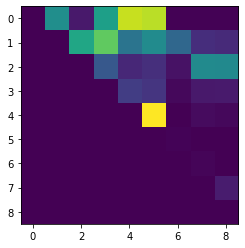

In [7]:
NN = len(trained['waics'][0])+1
WAICs = np.zeros((NN,NN))
for layer, ws in enumerate(trained['waics']):
    WAICs[layer,(layer+1):] = [-a for a in ws]
plt.imshow(WAICs[:])

In [8]:
device='cuda:0' # can be cuda, but no need for this here
test_x = torch.tensor(trained['Xt'], device=device).float()
test_y = torch.tensor(trained['Yt'], device=device).float()

# load old result that was reported in arXiv preprint. For comparison.
with open(f"/home/nina/CopulaGP/examples/super_vine.pkl","rb") as f:
    [Svine,y] = pkl.load(f)
lls_true = []
for i in range(9):
    lls_true.append(Svine.truncate(8-i).log_prob(test_y).mean().item())
lls_true

[0.0,
 1.7280809879302979,
 3.257986068725586,
 4.179661750793457,
 4.424014568328857,
 5.006869316101074,
 5.006869316101074,
 5.012329578399658,
 5.067294120788574]

In [9]:
# now calculate the new result with the newly trained model and divide by the old one
from vine import CVine
vine_base = CVine.mean(trained['models'],test_x,device=device)
lls = []
for i in range(9):
    lls.append(vine_base.truncate(8-i).log_prob(test_y).mean()/lls_true[i])
# Should be all ~100%
lls

[tensor(nan, device='cuda:0'),
 tensor(0.9723, device='cuda:0'),
 tensor(0.9974, device='cuda:0'),
 tensor(0.9992, device='cuda:0'),
 tensor(1.0100, device='cuda:0'),
 tensor(1.0078, device='cuda:0'),
 tensor(1.0087, device='cuda:0'),
 tensor(1.0091, device='cuda:0'),
 tensor(1.0090, device='cuda:0')]

In [10]:
# plt.plot(lls)
vine_base.entropy(v=True,sem_tol=0.1,mc_size=2000)

tensor([-6.1480, -5.3172, -4.7500,  ..., -3.7883, -5.8220, -4.5229],
       device='cuda:0')

array(-4.4150195, dtype=float32)

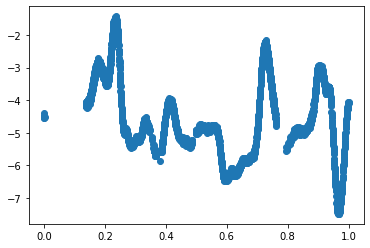

In [13]:
plt.scatter(trained['Xt'],Out[10].cpu().numpy())
Out[10].mean().cpu().numpy()

In [14]:
# calculate marginal conditional entropies H(Y_i|X)
from MI import HYgX
HYgX(numbers[::10,0],numbers[::10,1:])

[-0.4644114601357468,
 -4.035260913017335,
 -3.5092102960964366,
 0.719709552899566,
 -0.5957357626645103,
 2.0451934728738768,
 -2.969559773011402,
 -8.129654753998272]

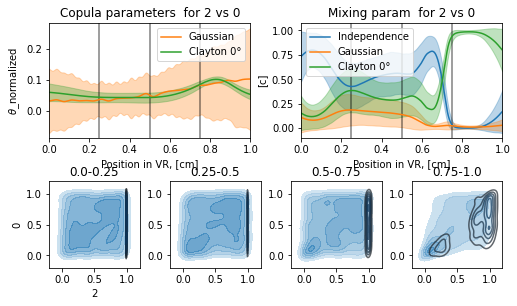

In [16]:
from utils import Plot_Fit

Plot_Fit(trained['models'][0][1].model_init('cpu'), d['X'], d['Y'][:,[2,0]], '2', '0', torch.device('cpu'), order = None);
# d['Y'].shape